# Reading and Displaying BTC Time Series Data

Source: [builtin.com/data-science/time-series-forecasting-python](https://builtin.com/data-science/time-series-forecasting-python)

We will start by reading in the historical prices for BTC using the Pandas data reader.

## Import Library

Import the data-reader from the Pandas library or you can also use yfinance.

In [1]:
import pandas_datareader.data as web
import yfinance as yf

Let’s also import the Pandas library itself and relax the display limits on columns and rows

In [2]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

We can now import the date-time library, which will allow us to define start and end dates for our data pull

In [3]:
import datetime

## Collect Data

Now we have everything we need to pull Bitcoin price time series data, let’s collect data.

In [4]:
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2020, 12, 2)

btc_data = yf.download('BTC-USD', start=start_date, end=end_date)
btc = pd.DataFrame(btc_data)

btc.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


We see that our data frame contains many columns. Let’s walk through what each of these columns means.
1. Date: This is the index in our time series that specifies the date associated with the price.
2. Close: The last price at which BTC was purchased on that day.
3. Open: The first price at which BTC was purchased on that day.
4. High: The highest price at which BTC was purchased that day.
5. Low: The lowest price at which BTC was purchased that day.
6. Volume: The number of total trades that day.
7. Adj Close: The closing price adjusted for dividends and stock splits.

We’ll use the close price for our forecasting models. Specifically, we will use historical closing BTC prices in order to predict future BTC ones. 

## Save & Load BTC File

Let’s write our closing price BTC data to a csv file. This way, we can avoid having to repeatedly pull data using the Pandas data reader.

In [5]:
btc.to_csv("btc.csv")

Now, let’s read in our csv file and display the first five rows.

In [6]:
btc = pd.read_csv("btc.csv", usecols=['Date', 'Close'])
btc.head()

,Date,Close
0,2018-01-01,13657.200195
1,2018-01-02,14982.099609
2,2018-01-03,15201.000000
3,2018-01-04,15599.200195
4,2018-01-05,17429.500000


## Manipulate the Data

In order to use the models provided by the stats library, we need to set the date column to be a data frame index. We also should format that date using the to_datetime method.

In [7]:
btc.index = pd.to_datetime(btc['Date'], format='%Y-%m-%d')
del btc['Date']

Let’s display our data frame.

In [8]:
btc.head()

,Close
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


## Plotting the Data

Let’s plot our time series data. To do this, let’s import the data visualization libraries Seaborn and Matplotlib.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

Let’s format our visualization using Seaborn.

In [10]:
sns.set()

And label the y-axis and x-axis using Matplotlib. We will also rotate the dates on the x-axis so that they’re easier to read. And finally, generate our plot with Matplotlib

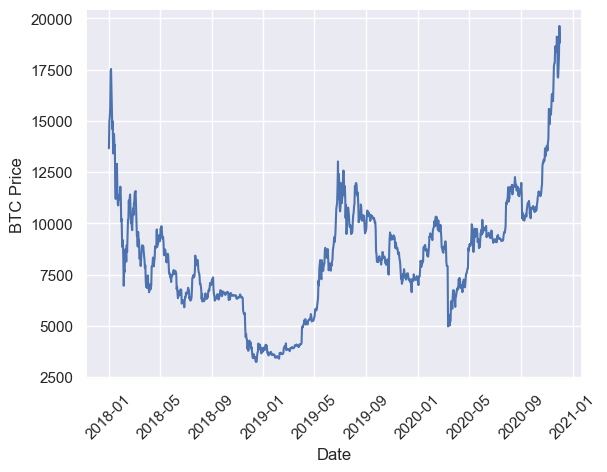

In [11]:
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['Close'])

Now we can proceed to building our first time series model, the Autoregressive Moving Average.

# Splitting Data for Training and Testing

An important part of model building is splitting our data for training and testing, which ensures that you build a model that can generalize outside of the training data and that the performance and outputs are statistically meaningful.

We will split our data such that everything before November 2020 will serve as training data, with everything after 2020 becoming the testing data.

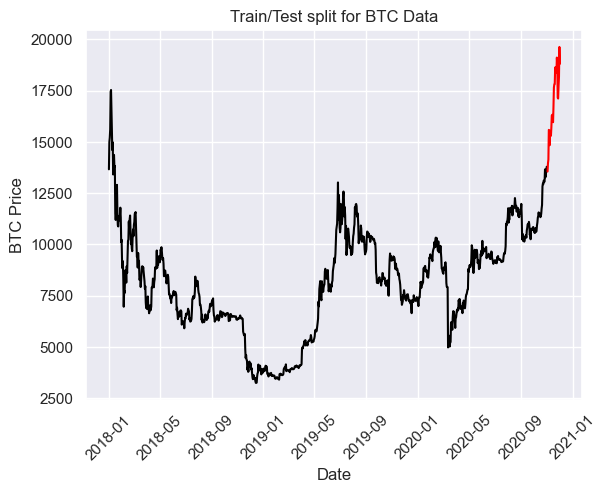

In [12]:
train = btc[btc.index < pd.to_datetime("2020-11-01", format='%Y-%m-%d')]
test = btc[btc.index > pd.to_datetime("2020-11-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

# Autoregressive Moving Average (ARMA) Model 

The term “autoregressive” in ARMA means that the model uses past values to predict future ones. Specifically, predicted values are a weighted linear combination of past values. This type of regression method is similar to linear regression, with the difference being that the feature inputs here are historical values. 

Moving average refers to the predictions being represented by a weighted, linear combination of white noise terms, where white noise is a random signal. The idea here is that ARMA uses a combination of past values and white noise in order to predict future values. Autoregression models market participant behavior like buying and selling BTC. The white noise models shock events like wars, recessions and political events. 

We can define an ARMA model using the SARIMAX package

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Let’s define our input

In [14]:
y = train['Close']

And then let’s define our model. To define an ARMA model with the SARIMAX class, we pass in the order parameters of (1, 0 ,1). Alpha corresponds to the significance level of our predictions. Typically, we choose an alpha = 0.05. Here, the ARIMA algorithm calculates upper and lower bounds around the prediction such that there is a five percent chance that the real value will be outside of the upper and lower bounds. This means that there is a 95 percent confidence that the real value will be between the upper and lower bounds of our predictions.

In [15]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


We can then fit our model

In [16]:
ARMAmodel = ARMAmodel.fit()

Generate our predictions

In [17]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

And plot the results

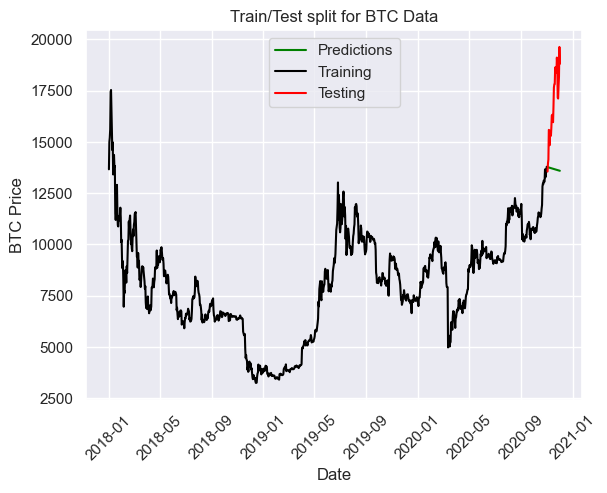

In [18]:
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.legend()
plt.show()

We can also evaluate the performance using the root mean-squared error

In [19]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  3562.13556446979


The RMSE is pretty high, which we could have guessed upon inspecting the plot. Unfortunately, the model predicts a decrease in price when the price actually increases. Again, ARMA is limited in that it fails for non-stationary time series and does not capture seasonality. Let’s see if we can improve performance with an ARIMA model.

# Autoregressive Integrated Moving Average (ARIMA) Model

Let’s import the ARIMA package from the stats library

In [20]:
from statsmodels.tsa.arima.model import ARIMA

An ARIMA task has three parameters. The first parameter corresponds to the lagging (past values), the second corresponds to differencing (this is what makes non-stationary data stationary), and the last parameter corresponds to the white noise (for modeling shock events). 

Let’s define an ARIMA model with order parameters (2,2,2)

In [21]:
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [22]:
y_pred2 = ARIMAmodel.get_forecast(len(test.index))
y_pred_df2 = y_pred2.conf_int(alpha = 0.05) 
y_pred_df2["Predictions"] = ARIMAmodel.predict(start = y_pred_df2.index[0], end = y_pred_df2.index[-1])
y_pred_df2.index = test.index
y_pred_out2 = y_pred_df2["Predictions"] 

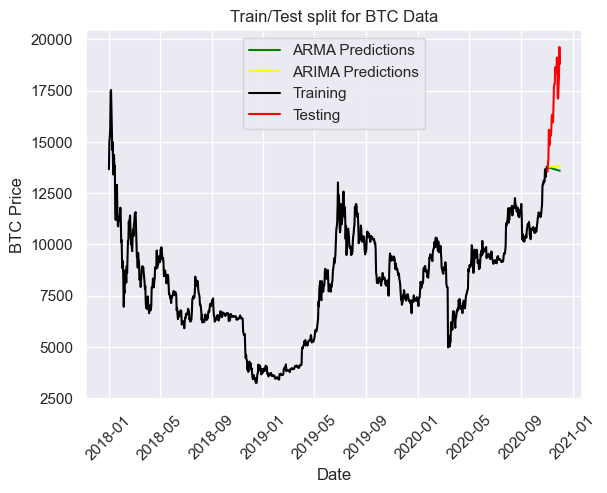

In [23]:
plt.plot(y_pred_out, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_out2, color='Yellow', label = 'ARIMA Predictions')
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.legend()
plt.show()

In [24]:
arima_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df2["Predictions"]))
print("RMSE: ",arima_rmse)

RMSE:  3423.3138876542403


We see that the ARIMA predictions (in yellow) fall on top of the ARMA predictions. Let’s try increasing the differencing parameter to ARIMA (2,3,2)

In [25]:
ARIMAmodel = ARIMA(y, order = (2, 3, 2))
ARIMAmodel = ARIMAmodel.fit()

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\hp\AppData\Local\Programs\Python\P

In [26]:
y_pred2 = ARIMAmodel.get_forecast(len(test.index))
y_pred_df2 = y_pred2.conf_int(alpha = 0.05) 
y_pred_df2["Predictions"] = ARIMAmodel.predict(start = y_pred_df2.index[0], end = y_pred_df2.index[-1])
y_pred_df2.index = test.index
y_pred_out2 = y_pred_df2["Predictions"] 

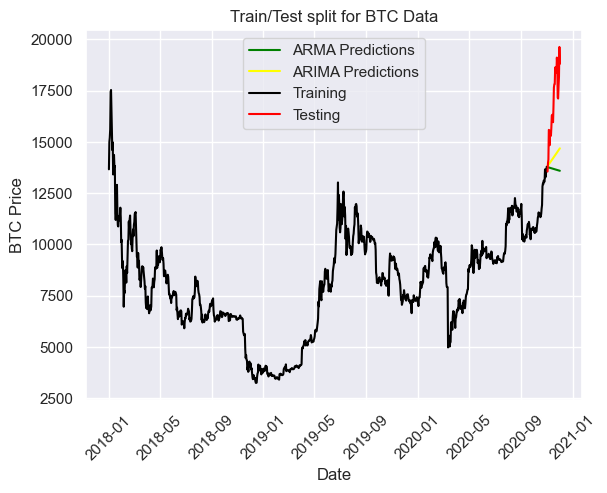

In [27]:
plt.plot(y_pred_out, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_out2, color='Yellow', label = 'ARIMA Predictions')
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.legend()
plt.show()

In [28]:
arima_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df2["Predictions"]))
print("RMSE: ",arima_rmse)

RMSE:  2929.0229863364643


We see this helps capture the increasing price direction. Let’s try playing with the parameters even further with ARIMA(5,4,2)

In [29]:
ARIMAmodel = ARIMA(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\hp\AppData\Local\Programs\Python\P

In [30]:
y_pred2 = ARIMAmodel.get_forecast(len(test.index))
y_pred_df2 = y_pred2.conf_int(alpha = 0.05) 
y_pred_df2["Predictions"] = ARIMAmodel.predict(start = y_pred_df2.index[0], end = y_pred_df2.index[-1])
y_pred_df2.index = test.index
y_pred_out2 = y_pred_df2["Predictions"] 

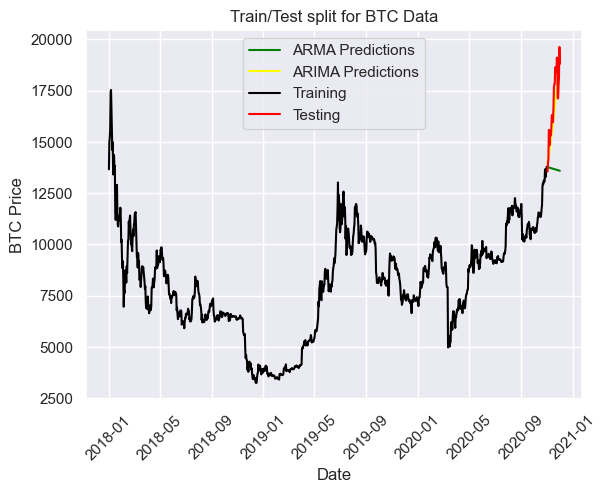

In [31]:
plt.plot(y_pred_out, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_out2, color='Yellow', label = 'ARIMA Predictions')
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.legend()
plt.show()

In [32]:
arima_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df2["Predictions"]))
print("RMSE: ",arima_rmse)

RMSE:  909.9019003543547


And we have an RMSE of 909.9, which is better than ARMA. Another approach is to train a linear regression model on temporal features such as week, month, and year. This approach is limited since it does not capture autoregressive and moving average features like the ARIMA method. Further, ARIMA trains regressors on detrended lagged target values as opposed to independent variables like linear regression. With this being said ARIMA would likely outperform a linear regression model trained on independent temporal variables. 

Finally, let’s see if SARIMA, which incorporates seasonality, will further improve performance.

# Seasonal ARIMA (SARIMA) Model

Seasonal ARIMA captures historical values, shock events and seasonality. We can define a SARIMA model using the SARIMAX class

In [33]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
y_pred3 = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df3 = y_pred3.conf_int(alpha = 0.05) 
y_pred_df3["Predictions"] = SARIMAXmodel.predict(start = y_pred_df3.index[0], end = y_pred_df3.index[-1])
y_pred_df3.index = test.index
y_pred_out3 = y_pred_df3["Predictions"] 

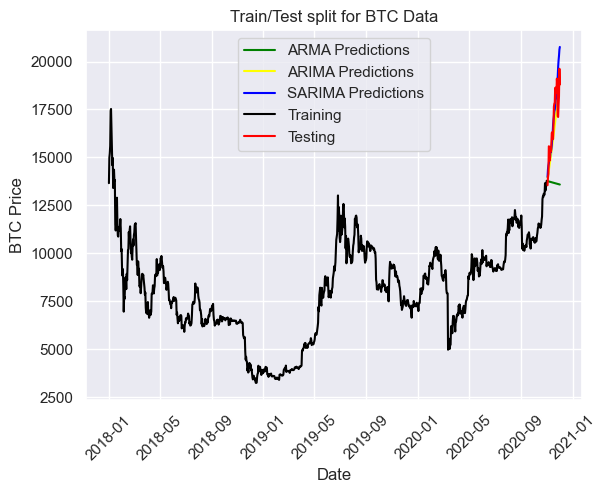

In [35]:
plt.plot(y_pred_out, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_out2, color='Yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_out3, color='Blue', label = 'SARIMA Predictions')
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.legend()
plt.show()

In [36]:
sarima_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df3["Predictions"]))
print("RMSE: ",sarima_rmse)

RMSE:  1021.7427419436364


Here we have an RMSE of 1021, which is slightly worse than ARIMA. This may be due to lack of hyperparameter tuning. If we play around with the parameters for our SARIMA model we should be able to improve performance even further.